### :
    当模型在训练数据集上更准确时，它在测试数据集上却不一定更准确

### 训练误差和泛化误差:
    训练误差（training error）:模型在训练数据集上表现出的误差
    泛化误差（generalization error）:模型在任意一个测试数据样本上表现出的误差的期望
    
    由于模型的参数是通过在训练数据集上训练模型而学习出的，参数的选择依据了最小化训练误差，所以，训练误差的期望应小于或等于泛化误差
        即由训练数据集学到的模型参数会使模型在训练数据集上的表现优于或等于在测试数据集上的表现
    
    一味地降低训练误差并不意味着泛化误差一定会降低

### 模型选择

#### 验证数据集:
    测试集只能在所有超参数和模型参数选定后使用一次。不可以使用测试数据选择模型，如调参
    可以预留一部分在训练数据集和测试数据集以外的数据来进行模型选择,这部分数据被称为验证数据集，简称验证集（validation set）

#### K 折交叉验证:
    在 K 折交叉验证中，把原始训练数据集分割成 K 个不重合的子数据集
    然后做 K 次模型训练和验证。每一次，使用一个子数据集验证模型，并使用其他 K - 1 个子数据集来训练模型
    最后，通过对 K 次实验的结果取平均来估计训练和验证误差

### 欠拟合和过拟合:
    比较训练和验证误差时,会出现两种常见的情况：
        欠拟合：训练误差和验证误差都很严重,意味着模型过于简单（即表达能力不足），无法捕获试图学习的模式
        过拟合：训练误差明显低于验证误差
![overfitting_underfitting](./img/3.7/overfitting_underfitting.png)

#### 模型复杂度:
    以多项式函数拟合为例,高阶多项式函数模型参数更多,所以高阶多项式函数比低阶多项式函数的复杂度更高
        即模型的复杂度过低，很容易出现欠拟合；模型复杂度过高，很容易出现过拟合

#### 训练数据集大小:(影响欠拟合和过拟合的另一个重要因素)
    训练数据集中样本数过少，尤其是比模型参数数量更少时，过拟合更容易发生

#### 多项式函数拟合实验
![polynomial](./img/3.7/polynomial.png)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
# y = 1.2x - 3.4x^2 + 5.6x^3 + 5 + ε
n_train,n_test = 100,100 # 训练和测试数据集大小
true_w,true_b = [1.2,-3.4,5.6],5
features = torch.randn((n_train + n_test),1)
poly_features = torch.cat((features,torch.pow(features,2),torch.pow(features,3)),dim=1) # torch.Size([200, 3])
labels = true_w[0] * poly_features[:,0] + true_w[1] * poly_features[:,1] + true_w[2] * poly_features[:,2] + true_b
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float)

features.shape,poly_features.shape,labels.shape

(torch.Size([200, 1]), torch.Size([200, 3]), torch.Size([200]))

In [3]:
features[:2],poly_features[:2],labels[:2]

(tensor([[0.3702],
         [1.3578]]),
 tensor([[0.3702, 0.1370, 0.0507],
         [1.3578, 1.8435, 2.5031]]),
 tensor([ 5.2579, 14.3821]))

In [4]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(20,8)):
    plt.figure(figsize=figsize,dpi=80)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

In [5]:
num_epochs = 100
def fit_and_plot(train_features,test_features,train_labels,test_labels):
    net = torch.nn.Linear(train_features.shape[-1],1)
    
    batch_size = min(10,train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
    train_ls,test_ls = [],[]
    for _ in range(num_epochs):
        for x,y in train_iter:
            y_hat = net(x)
            loss = loss_fn(y_hat,y.view(-1,1))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_labels = train_labels.view(-1,1)
        test_labels = test_labels.view(-1,1)
        train_ls.append(loss_fn(net(train_features),train_labels).item())
        test_ls.append(loss_fn(net(test_features),test_labels).item())
        
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1,num_epochs+1),train_ls,'epochs','loss',
            x2_vals=range(1,num_epochs+1),y2_vals=test_ls,legend=['train','test'])
    print('weight:', net.weight.data,
          '\nbias:', net.bias.data)

final epoch: train loss 7.733132224529982e-05 test loss 8.7188214820344e-05
weight: tensor([[ 1.1966, -3.3995,  5.6010]]) 
bias: tensor([4.9993])


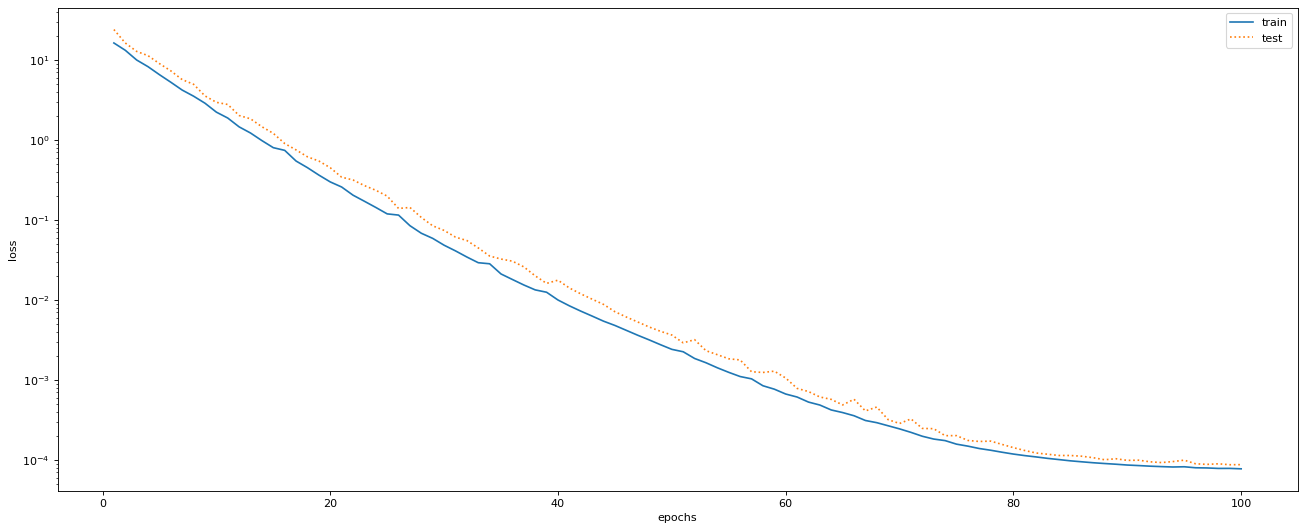

In [6]:
# 三阶多项式函数拟合（正常）
fit_and_plot(poly_features[:n_train],poly_features[n_train:],labels[:n_train],labels[n_train:])

final epoch: train loss 198.52703857421875 test loss 263.83050537109375
weight: tensor([[18.0228]]) 
bias: tensor([0.3908])


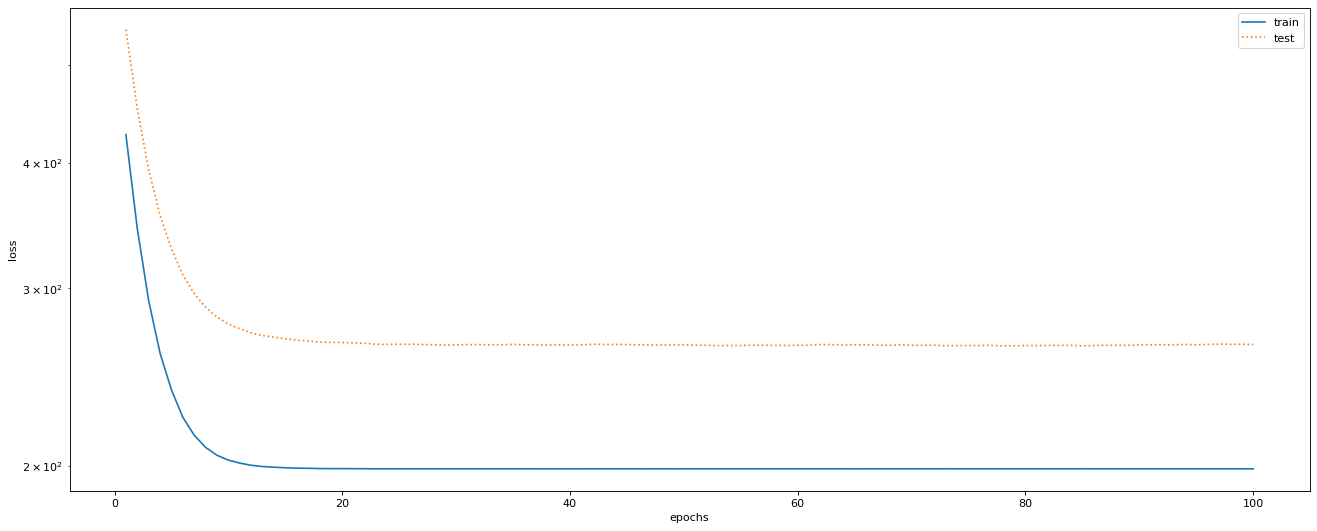

In [7]:
# 线性函数拟合（欠拟合）
fit_and_plot(features[:n_train],features[n_train:],labels[:n_train],labels[n_train:])

final epoch: train loss 1.1349159479141235 test loss 283.2279052734375
weight: tensor([[2.2586, 1.8355, 2.2382]]) 
bias: tensor([2.5693])


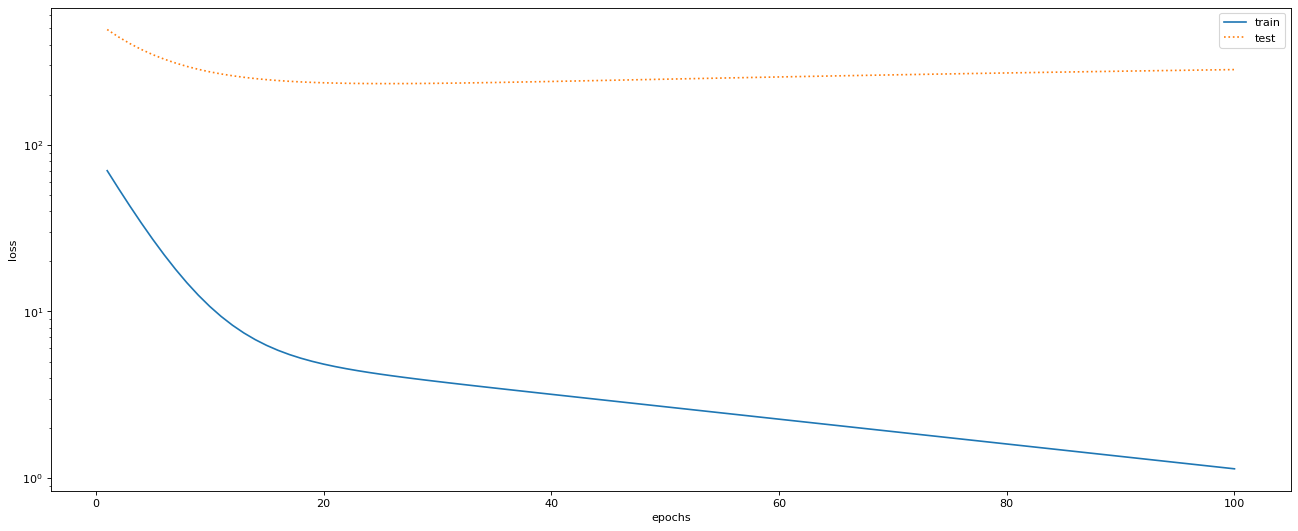

In [8]:
# 训练样本不足（过拟合）
fit_and_plot(poly_features[0:2,:],poly_features[n_train:,:],labels[0:2],labels[n_train:])